In [1]:
import sys
sys.path.append('../gtm/')
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from random import random
import torch
import pandas as pd
from tqdm import tqdm
from corpus_multilingual import GTMCorpus_Multilingual
from gtm_multilingual import GTM_Multilingual
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

/home/germain/Documents/topic models/generalized_topic_model_dev/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_doc(
    i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, language
):
    doc_length = np.random.randint(min_words, max_words + 1)
    doc_topic_matrix = true_doc_topic_matrix[i]
    doc_words = []
    topic_word_matrix = topic_word_matrices[language]
    vocab_size = topic_word_matrix.shape[1]
    for _ in range(doc_length):
        word_probs = np.dot(doc_topic_matrix, topic_word_matrix)
        word_probs /= np.sum(word_probs)
        word_index = np.random.choice(vocab_size, p=word_probs)
        doc_words.append(f'{language}_word_{word_index}')
    doc = ' '.join(doc_words)
    return doc

def generate_documents(
    num_docs,
    num_topics,
    vocab_size,
    num_covs,
    lambda_,
    sigma,
    doc_topic_prior,
    min_words,
    max_words,
    random_seed,
    align_proportion=0.1,
    num_jobs=1
):
    topicnames = [f"Topic{i}" for i in range(num_topics)]
    words = {
        'lang1': [f"lang1_word_{i}" for i in range(vocab_size)],
        'lang2': [f"lang2_word_{i}" for i in range(vocab_size)]
    }
    cov_names = [f"cov_{i}" for i in range(num_covs + 1)]
    
    if random_seed is not None:
        np.random.seed(random_seed)

    if num_covs > 0:
        M_prevalence_covariates = np.zeros((num_docs, num_covs + 1), dtype=int)
        M_prevalence_covariates[:, 0] = 1
        for i in range(num_covs):
            M_prevalence_covariates[:, i + 1] = np.random.randint(2, size=num_docs)

    if num_covs > 0:
        alpha = np.exp(np.dot(M_prevalence_covariates, lambda_))
    else:
        alpha = np.array([[0.1 for _ in range(num_topics)] for _ in range(num_docs)])

    if doc_topic_prior == 'dirichlet':
        samples = []
        for a in alpha:
            sample = np.random.dirichlet(a)
            samples.append(sample)
        true_doc_topic_matrix = np.array(samples)
    else:
        if num_covs > 0:
            mean = np.dot(M_prevalence_covariates, lambda_)
        else:
            mean = np.array([[0 for _ in range(num_topics)] for _ in range(num_docs)])
            sigma = np.eye(num_topics)
        samples = []
        for m in mean:
            sample = np.random.multivariate_normal(m, sigma)
            sample = np.exp(sample) / np.exp(sample).sum()
            samples.append(sample)
        true_doc_topic_matrix = np.array(samples)

    beta = [0.1 for _ in range(vocab_size)]
    topic_word_matrices = {
        'lang1': np.random.dirichlet(beta, num_topics),
        'lang2': np.random.dirichlet(beta, num_topics)
    }

    num_aligned = int(num_docs * align_proportion)
    aligned_indices = np.random.choice(num_docs, num_aligned, replace=False)

    documents_lang1, documents_lang2, groups = [], [], []
    doc_topic_rows = []

    for i in tqdm(range(num_docs)):
        if i in aligned_indices:
            lang1_doc = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, 'lang1')
            lang2_doc = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, 'lang2')
            documents_lang1.append(lang1_doc)
            documents_lang2.append(lang2_doc)
            groups.append(i)
        else:
            lang = np.random.choice(['lang1', 'lang2'])
            if lang == 'lang1':
                doc = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, lang)
                documents_lang1.append(doc)
                documents_lang2.append(None)
            else:
                doc = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, lang)
                documents_lang1.append(None)
                documents_lang2.append(doc)
            groups.append(i)
        doc_topic_rows.append(true_doc_topic_matrix[i])

    df = pd.DataFrame({
        "doc_clean_1": documents_lang1,
        "doc_clean_2": documents_lang2
    })
    
    if num_covs > 0:
        cov_df = pd.DataFrame(M_prevalence_covariates, columns=cov_names)
        df = pd.concat([df, cov_df], axis=1)

    topicnames = [f"Topic{i}" for i in range(num_topics)]
    df_doc_topic = pd.DataFrame(doc_topic_rows, columns=topicnames)
    df_true_dist_list = [df_doc_topic]

    return df_true_dist_list, df

In [3]:
align_proportion = 1 # 0 or 1

df_true_dist_list, df = generate_documents(
    num_docs=10000, 
    num_topics=2, 
    vocab_size=500, 
    num_covs=0,
    lambda_=np.random.randn(2, 2), 
    sigma=np.eye(2),
    doc_topic_prior='logistic_normal',
    min_words=100, 
    max_words=100, 
    random_seed=0,
    align_proportion=align_proportion,
    num_jobs=1
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:01<00:00, 82.34it/s]


In [4]:
df

,doc_clean_1,doc_clean_2
0,lang1_word_459 lang1_word_15 lang1_word_350 la...,lang2_word_482 lang2_word_55 lang2_word_466 la...
1,lang1_word_257 lang1_word_94 lang1_word_109 la...,lang2_word_431 lang2_word_367 lang2_word_246 l...
2,lang1_word_217 lang1_word_280 lang1_word_110 l...,lang2_word_388 lang2_word_274 lang2_word_350 l...
3,lang1_word_402 lang1_word_148 lang1_word_97 la...,lang2_word_316 lang2_word_350 lang2_word_482 l...
4,lang1_word_235 lang1_word_215 lang1_word_116 l...,lang2_word_62 lang2_word_167 lang2_word_454 la...
...,...,...
9995,lang1_word_50 lang1_word_466 lang1_word_201 la...,lang2_word_36 lang2_word_355 lang2_word_369 la...
9996,lang1_word_12 lang1_word_487 lang1_word_307 la...,lang2_word_208 lang2_word_301 lang2_word_206 l...
9997,lang1_word_112 lang1_word_274 lang1_word_389 l...,lang2_word_350 lang2_word_261 lang2_word_199 l...
9998,lang1_word_381 lang1_word_327 lang1_word_434 l...,lang2_word_62 lang2_word_187 lang2_word_36 lan...


In [5]:
train_dataset = GTMCorpus_Multilingual(
    df,
)

In [6]:
tm = GTM_Multilingual(
    train_dataset,
    n_topics = 2,
    doc_topic_prior = "logistic_normal",
    batch_size = 64,
    dropout = 0
)


Epoch   1	Mean Training Loss:969.0347551

Topic_0: ['lang1_word_94', 'lang1_word_97', 'lang1_word_327', 'lang1_word_274', 'lang1_word_18', 'lang1_word_404', 'lang1_word_311', 'lang1_word_412']
Topic_1: ['lang1_word_233', 'lang1_word_72', 'lang1_word_389', 'lang1_word_459', 'lang1_word_215', 'lang1_word_390', 'lang1_word_110', 'lang1_word_359']



Epoch   2	Mean Training Loss:946.7055960

Topic_0: ['lang1_word_94', 'lang1_word_97', 'lang1_word_327', 'lang1_word_18', 'lang1_word_274', 'lang1_word_148', 'lang1_word_311', 'lang1_word_404']
Topic_1: ['lang1_word_233', 'lang1_word_72', 'lang1_word_389', 'lang1_word_459', 'lang1_word_215', 'lang1_word_390', 'lang1_word_359', 'lang1_word_110']



Epoch   3	Mean Training Loss:946.5200600

Topic_0: ['lang1_word_94', 'lang1_word_97', 'lang1_word_327', 'lang1_word_274', 'lang1_word_404', 'lang1_word_18', 'lang1_word_148', 'lang1_word_311']
Topic_1: ['lang1_word_233', 'lang1_word_72', 'lang1_word_389', 'lang1_word_215', 'lang1_word_459', 'lang1_wo

In [7]:
estimated_doc_topics = tm.get_doc_topic_distribution(train_dataset)

In [8]:
df_true_dist_list

[        Topic0    Topic1
 0     0.796392  0.203608
 1     0.220603  0.779397
 2     0.945051  0.054949
 3     0.750531  0.249469
 4     0.374299  0.625701
 ...        ...       ...
 9995  0.409655  0.590345
 9996  0.064797  0.935203
 9997  0.216758  0.783242
 9998  0.487068  0.512932
 9999  0.324668  0.675332
 
 [10000 rows x 2 columns]]

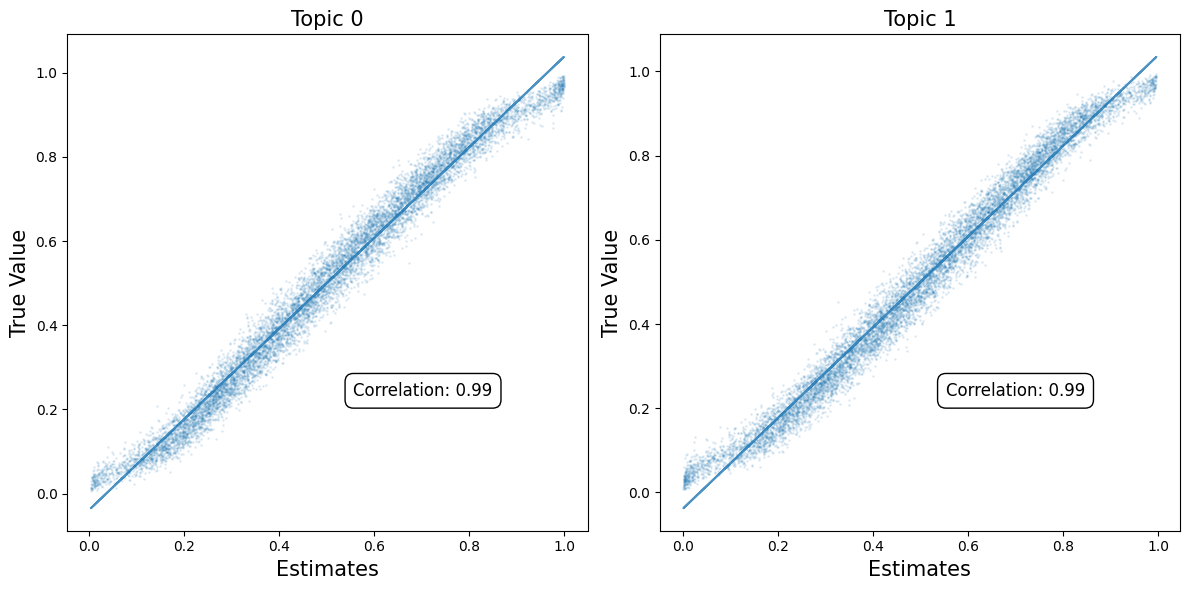

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

# Define colors for each language
colors = {'lang1': 'black', 'lang2': 'green'}

for i in range(2):  
    x = 1-estimated_doc_topics[:,i]
    y = df_true_dist_list[0]['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title('Topic {}'.format(i), fontsize=15)

    # Calculate correlation coefficient
    corr_coeff = np.corrcoef(x, y)[0, 1]
    # Add annotation
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                 fontsize=12, verticalalignment='top', horizontalalignment='left',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout() 
plt.savefig('../figs/true_vs_estimated_sample_multiligual_{}.pdf'.format(align_proportion))